# ADA 2018 - Homework 3



## Undestanding the StackOverflow community


Deadline: Nov 7th 2018, 23:59:59

Submission link: Check channel homework-3-public

StackOverflow is the most popular programming-related Q&A website. It serves as a platform for users to ask and answer questions and to vote questions and answers up or down. Users of StackOverflow can earn reputation points and "badges"; for example, a person is awarded 10 reputation points for receiving an "up" vote on an answer given to a question, and 5 points for the "up" vote on a question asked. Also, users receive badges for their valued contributions, which represents a kind of gamification of the traditional Q&A site. 

[Learn more about StackOverflow on Wikipedia](https://en.wikipedia.org/wiki/Stack_Overflow)

----

Dataset link:

https://drive.google.com/open?id=1POlGjqzw9v_pZ_bUnXGihOgk45kbvNjB

http://iccluster053.iccluster.epfl.ch/Posts.json.zip (mirror 1)

https://iloveadatas.com/datasets/Posts.json.zip (mirror 2)

Dataset description:

* **Id**: Id of the post
* **CreationDate**: Creation date of the post (String format)
* **PostTypeId**: Type of post (Question = 1, Answer = 2)
* **ParentId**: The id of the question. Only present if PostTypeId = 2
* **Score**: Points assigned by the users
* **Tags**: Tags of the question. Only present if PostTypeId = 1
* **Title**: Only present if PostTypeId = 1
* **ViewCount**: Only present if PostTypeId = 1

The dataset format is JSON. Here are examples of a question and an answer:

Question:
```json
{
    "Id": 10130734,
    "CreationDate": "2012-04-12T19:51:25.793+02:00",
    "PostTypeId": 1,
    "Score": 4,
    "Tags": "<python><pandas>",
    "Title": "Best way to insert a new value",
    "ViewCount": 3803
}
```

Answer:
```json
{  
   "CreationDate":"2010-10-26T03:19:05.063+02:00",
   "Id":4020440,
   "ParentId":4020214,
   "PostTypeId":2,
   "Score":1
}
```

----
Useful resources:

**Spark SQL, DataFrames and Datasets Guide**

https://spark.apache.org/docs/latest/sql-programming-guide.html

**Database schema documentation for the public data dump**

https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede

----

**Note:** Use Spark where possible. Some computations can take more than 10 minutes on a common notebook. Consider to save partial results on disk.

In [2]:
# Add your imports here
# import pandas as pd
# import numpy as np
# import scipy as sp
# from pyspark.sql import *
# %matplotlib inline

# spark = SparkSession.builder.getOrCreate()
import re
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

#to check code speed
import time
def print_exec_time(start_time):
    print('Execution time {} [s]'.format(np.floor((time.time() - start_time)*1000)/1000))
    
#set up some global variables
ID_QUESTION = 1
ID_ANSWER = 2

### Task A: Convert the dataset to a more convenient format
As a warm-up task (and to avoid to warm up your laptop too much), load the dataset into a Spark dataframe, show the content, and save it in the _Parquet_ format. Use this step to convert the fields to a more convenient form.

Answer the following questions:

1. How many questions have been asked on StackOverflow?
2. How many answers have been given?
3. What is the percentage of questions with a score of 0?

**Hint:** The next tasks involve a time difference. Consider storing time in numeric format.

In [3]:
# In order to load the data directly from the parquet once it has been create.
# We first try to read the parquet if it doesn't work we read the json then overwrite the parquet.
# This solution seems more elegant than comment the code to read write the JSON or to not run all cells.
try:
    posts = spark.read.json('Posts.json')
    print('read post')
    posts.write.mode('overwrite').parquet("posts.parquet")
    print('Wrote paquet')
except:
    posts = spark.read.parquet("posts.parquet")

# Question
1-  How many questions have been asked on StackOverflow?

In [4]:
start_time = time.time()
#Getting all the questions
nb_questions = posts.filter(posts.PostTypeId == ID_QUESTION).count()
print_exec_time(start_time)
print('{} questions have been asked on StackOverflow (according to our data)'.format(nb_questions))

Execution time 2.12 [s]
15647060 questions have been asked on StackOverflow (according to our data)


# Question
2- How many answers have been given?

In [5]:
start_time = time.time()
#Getting all the answers
nb_answers=posts.filter(posts.PostTypeId == ID_ANSWER).count()
print_exec_time(start_time)
print('{} answers have been given on StackOverflow (according to our data)'.format(nb_answers))

Execution time 0.63 [s]
25192772 answers have been given on StackOverflow (according to our data)


# Question
3- What is the percentage of questions with a score of 0?

In [6]:
start_time = time.time()
nb_questions_scor0 = posts.filter((posts.PostTypeId == ID_QUESTION) & (posts.Score == 0)).count()
print_exec_time(start_time)
print('The percentage of question with a score of zero is {}'.format(int(nb_questions_scor0/nb_questions*10**4)/10**2))

Execution time 0.879 [s]
The percentage of question with a score of zero is 46.54


**Hint:** Load the dataset from the Parquet file for the next tasks.

### Task B: What are the 10 most popular tags?

What are the most popular tags in StackOverflow? Use Spark to extract the information you need, and answer the following questions with Pandas and Matplotlib (or Seaborn):

1. What is the proportion of tags that appear in fewer than 100 questions?
2. Plot the distribution of the tag counts using an appropriate representation.
3. Plot a bar chart with the number of questions for the 10 most popular tags.

For each task describe your findings briefly.

##### First, looking at the table 

In [7]:
posts.show(5)

+--------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
|        CreationDate|      Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|
+--------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
|2017-08-17T16:20:...|45740344|45740224|         2|    0|                null|                null|     null|
|2017-08-17T16:20:...|45740346|45739185|         2|    1|                null|                null|     null|
|2017-08-17T16:20:...|45740348|    null|         1|    2|<flash><react-nat...|Is it possible to...|      143|
|2017-08-17T16:20:...|45740350|45739102|         2|    1|                null|                null|     null|
|2017-08-17T16:20:...|45740352|42473616|         2|    0|                null|                null|     null|
+--------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
only showi

##### Then, removing the null tags

In [8]:
start_time = time.time()
posts_tagsClean = posts.filter(~posts.Tags.isNull())
print_exec_time(start_time)
#check it
posts_tagsClean.show(5)

Execution time 0.019 [s]
+--------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
|        CreationDate|      Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|
+--------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
|2017-08-17T16:20:...|45740348|    null|         1|    2|<flash><react-nat...|Is it possible to...|      143|
|2017-08-17T16:20:...|45740355|    null|         1|    1|<postgresql><form...|Remove trailing z...|      444|
|2017-08-17T16:21:...|45740358|    null|         1|    0|<python><websocke...|Python websockets...|      280|
|2017-08-17T16:21:...|45740363|    null|         1|    0|<facebook><facebo...|Image meta tag no...|       97|
|2017-08-17T16:21:...|45740371|    null|         1|    1|    <mongodb><shell>|Using Mongo-cli t...|      185|
+--------------------+--------+--------+----------+-----+--------------------+-----------------

##### They seem to be only question let's check if it is true

In [9]:
posts_tagsClean.filter(posts_tagsClean.PostTypeId != ID_QUESTION).count()

0

There is indeed only questions we will not have to check for the PostTypeId for the following

##### Now we explode the tags to get each individual tags

In [10]:
start_time = time.time()
posts_expoded = posts_tagsClean.withColumn('Tags', explode(split('Tags', '><')))
print_exec_time(start_time)
#check first 5 tags
posts_expoded.show(5)

Execution time 0.029 [s]
+--------------------+--------+--------+----------+-----+-------------+--------------------+---------+
|        CreationDate|      Id|ParentId|PostTypeId|Score|         Tags|               Title|ViewCount|
+--------------------+--------+--------+----------+-----+-------------+--------------------+---------+
|2017-08-17T16:20:...|45740348|    null|         1|    2|       <flash|Is it possible to...|      143|
|2017-08-17T16:20:...|45740348|    null|         1|    2|react-native>|Is it possible to...|      143|
|2017-08-17T16:20:...|45740355|    null|         1|    1|  <postgresql|Remove trailing z...|      444|
|2017-08-17T16:20:...|45740355|    null|         1|    1|   formatting|Remove trailing z...|      444|
|2017-08-17T16:20:...|45740355|    null|         1|    1|     plpgsql>|Remove trailing z...|      444|
+--------------------+--------+--------+----------+-----+-------------+--------------------+---------+
only showing top 5 rows



##### finally remove the < and >

In [10]:
start_time = time.time()
posts_final = posts_expoded.withColumn('Tags', regexp_replace('Tags', '<', '')).withColumn('Tags', regexp_replace('Tags', '>', ''))
print_exec_time(start_time)
#check first 5 tags without "<" and ">"
posts_final.show(5)

Execution time 0.168 [s]
+--------------------+--------+--------+----------+-----+------------+--------------------+---------+
|        CreationDate|      Id|ParentId|PostTypeId|Score|        Tags|               Title|ViewCount|
+--------------------+--------+--------+----------+-----+------------+--------------------+---------+
|2017-08-17T16:20:...|45740348|    null|         1|    2|       flash|Is it possible to...|      143|
|2017-08-17T16:20:...|45740348|    null|         1|    2|react-native|Is it possible to...|      143|
|2017-08-17T16:20:...|45740355|    null|         1|    1|  postgresql|Remove trailing z...|      444|
|2017-08-17T16:20:...|45740355|    null|         1|    1|  formatting|Remove trailing z...|      444|
|2017-08-17T16:20:...|45740355|    null|         1|    1|     plpgsql|Remove trailing z...|      444|
+--------------------+--------+--------+----------+-----+------------+--------------------+---------+
only showing top 5 rows



### We can now answer the questions

# Question
1- What is the proportion of tags that appear in fewer than 100 questions?

In [11]:
# One elegante solution is to use the SQL language to do it
posts_final.registerTempTable('posts_sql2')

In [12]:
start_time = time.time()
#Getting count of tags that appear in less than 100 questions
queryB1 = """
select Tags, count(*) as count_tags
from posts_sql2
group by Tags
having count_tags < 100
"""
resultB1 = spark.sql(queryB1)
nb_tag_less100 = resultB1.count()
print_exec_time(start_time)
print('The number of tags that appears in less than 100 questions is {}'.format(nb_tag_less100))
# resultB1.show()

Execution time 117.997 [s]
The number of tags that appears in less than 100 questions is 36025


In [13]:
start_time = time.time()
nb_distinct_tags = posts_final.filter(posts_final.PostTypeId == ID_QUESTION).dropDuplicates(['Tags']).count()
print_exec_time(start_time)
print('There is {} distinct tags'.format(nb_distinct_tags))

Execution time 121.712 [s]
There is 52994 distinct tags


In [14]:
proportion = nb_tag_less100 / nb_distinct_tags
print('The proportion of tags present in less that a hundred Questions is {}'.format(int(proportion*10**2)/10**2))

The proportion of tags present in less that a hundred Questions is 0.67


# Question
2- Plot the distribution of the tag counts using an appropriate representation.

Again let's use SQL language to do the query we are counting the number of time each tag appears.

In [15]:
start_time = time.time()
#counting the number of time each tag appears
queryB2 = """
select Tags, count(*) as count_tags
from posts_sql2
group by Tags
"""
resultB2 = spark.sql(queryB2)
pd_resultB2 = resultB2.select('count_tags').toPandas()
print_exec_time(start_time)

Execution time 120.803 [s]


A histogram is the basic choice to represent the distribution

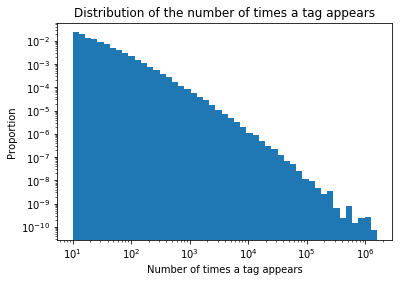

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(pd_resultB2.values, bins=np.logspace(1,np.log10(pd_resultB2.values.max()), 50), density=True)
fig.canvas.draw()
plt.yscale('log')
plt.xscale('log')
# plt.xticks(rotation=30)
plt.xlabel('Number of times a tag appears')
plt.ylabel('Proportion')
plt.title('Distribution of the number of times a tag appears')
plt.show()

# Question
3- Plot a bar chart with the number of questions for the 10 most popular tags.

In [17]:
start_time = time.time()
#Getting number of questions for the 10 most popular tags
queryB3 = """
select Tags, count(*) as count_tags
from posts_sql2
group by Tags
order by count_tags desc
limit 10
"""
resultB3 = spark.sql(queryB3)
pd_resultB3 = resultB3.toPandas()
print_exec_time(start_time)

Execution time 123.264 [s]


Let's check the result of this query

In [18]:
resultB3.show()

+----------+----------+
|      Tags|count_tags|
+----------+----------+
|javascript|   1585495|
|      java|   1352735|
|        c#|   1172492|
|       php|   1136082|
|   android|   1088811|
|    python|    954401|
|    jquery|    886982|
|      html|    725289|
|       ios|    551843|
|       c++|    536267|
+----------+----------+



This are very courant languages so the result makes perfect sense

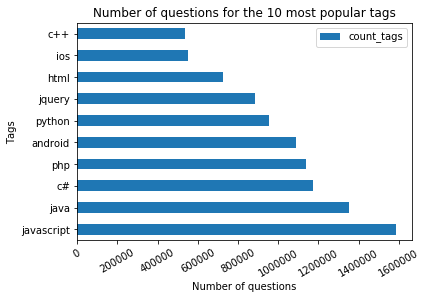

In [19]:
pd_resultB3.plot.barh(x='Tags')
plt.xticks(rotation=30)
plt.xlabel('Number of questions')
plt.title('Number of questions for the 10 most popular tags')
plt.show()

### Task C: View-score relation

We want to investigate the correlation between the view count and the score of questions.

1. Get the view count and score of the questions with tag ```random-effects``` and visualize the relation between these two variables using an appropriate plot.
2. Are these two variables correlated? Use the Pearson coefficient to validate your hypothesis. Discuss your findings in detail.

**Hint:** Inspect the data visually before drawing your conclusions.

# Question
1- Get questions with tag 'random-effect' and visualize the relation between these two variables using an appropriate plot.

In [20]:
start_time = time.time()
#Getting questions with tag 'random-effect' 
#we could only filter with the tags instead of filtering with ID_QUESTION because answers don't have tag
questions_ran_eff = posts.filter((posts.PostTypeId == ID_QUESTION) & (posts.Tags.contains('random-effect')))
print_exec_time(start_time)
pd_questions_ran_eff=questions_ran_eff.toPandas()

Execution time 0.176 [s]


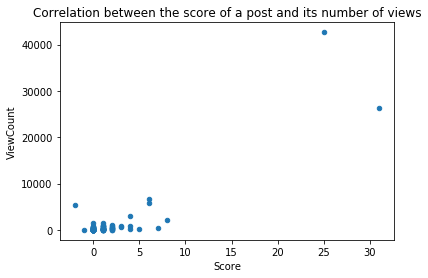

In [21]:
pd_questions_ran_eff.plot.scatter(x='Score', y='ViewCount')
plt.title('Correlation between the score of a post and its number of views')
plt.yscale('linear')
plt.show()

# Question
2- Are these two variables correlated? Use the Pearson coefficient to validate your hypothesis. Discuss your findings in detail.

The two variables seem positively correlated. This correlation is apparently due mainly to the two outliers.

In [22]:
#do Pearson
pd_questions_ran_eff[['Score', 'ViewCount']].corr(method='pearson')

,Score,ViewCount
Score,1.000000,0.882197
ViewCount,0.882197,1.000000


The Pearson coefficient indicates that there is indeed a strong positive linear correlation (0.88) between the score and the number of views of a post. 


In [23]:
#check what happens when we remove the outliers
pd_questions_ran_eff_noOutliers = pd_questions_ran_eff[pd_questions_ran_eff['Score']<15]

In [24]:
#do Pearson
pd_questions_ran_eff_noOutliers[['Score', 'ViewCount']].corr(method='pearson')

,Score,ViewCount
Score,1.000000,0.439389
ViewCount,0.439389,1.000000


The correlation is much weaker, which confirm that the outliers with a very high score and #view influence the most the correlation. 

### Task D: What are the tags with the fastest first answer?

What are the tags that have the fastest response time from the community? We define the response time as the difference in seconds between the timestamps of the question and of the first answer received.

1. Get the response time for the first answer of the questions with the tags ```python``` and ```java```.
2. Plot the two distributions in an appropriate format. What do you observe? Describe your findings and discuss the following distribution properties: mean, median, standard deviation.
3. We believe that the response time is lower for questions related to Python (compare to Java). Contradict or confirm this assumption by estimating the proper statistic with bootstrapping. Visualize the 95% confidence intervals with box plots and describe your findings.
3. Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.


# Question:
Get the response time for the first answer of the questions with the tags ```python``` and ```java```.

In [11]:
#Method with spark.sql is time consuming
'''posts.createOrReplaceTempView("raw_data")
java_tag = spark.sql("SELECT * from raw_data WHERE Tags == '<java_tag>'")
java_tag.collect()
java_tag.count()'''
#Getting all python and java tags from DF.filter
java_questions = posts.filter(posts.Tags.contains('java'))
python_questions = posts.filter(posts.Tags.contains('python'))

In [12]:
#Getting all the answers thanks to the post type: 2
answers_df = posts.filter(posts.PostTypeId=='2')

In [13]:
#Getting the Question Id qnd the creation date of java and python related questions
java_questions.createOrReplaceTempView("jq")
java_quest_columnId = spark.sql("SELECT Id AS QuestionId, CreationDate AS QuestionDate FROM jq")

python_questions.createOrReplaceTempView("pq")
python_quest_columnId = spark.sql("SELECT Id AS QuestionId, CreationDate AS QuestionDate FROM pq")

In [14]:
java_quest_columnId.createOrReplaceTempView("jqc")
python_quest_columnId.createOrReplaceTempView("pqc")
answers_df.createOrReplaceTempView("ad")

#Joining Question and Answer dataframes to get all the java and python answers
java_answers = spark.sql("SELECT * FROM jqc j INNER JOIN ad a ON j.QuestionId=a.ParentId")
python_answers = spark.sql("SELECT * FROM pqc p INNER JOIN ad a ON p.QuestionId=a.ParentId")

In [15]:
java_answers.createOrReplaceTempView("ja")
python_answers.createOrReplaceTempView("pa")
#Parsing date to convert them to date later on
java_answers_date_parsed = java_answers.withColumn('CreationDate', regexp_replace('CreationDate', ':', ''))
java_answers_date_parsed = java_answers_date_parsed.withColumn('QuestionDate', regexp_replace('QuestionDate', ':', ''))

python_answers_date_parsed = python_answers.withColumn('CreationDate', regexp_replace('CreationDate', ':', ''))
python_answers_date_parsed = python_answers_date_parsed.withColumn('QuestionDate', regexp_replace('QuestionDate', ':', ''))

In [16]:
from datetime import datetime
from pyspark.sql.types import TimestampType
#string to date conversion
func =  udf (lambda x: datetime.strptime(x,"%Y-%m-%dT%H%M%S.%f%z"), TimestampType())

#Converting string to date
java_answers_date_converted = java_answers_date_parsed.withColumn('QuestionDate', func(col('QuestionDate')))
java_answers_date_converted = java_answers_date_converted.withColumn('CreationDate', func(col('CreationDate')))

python_answers_date_converted = python_answers_date_parsed.withColumn('QuestionDate', func(col('QuestionDate')))
python_answers_date_converted = python_answers_date_converted.withColumn('CreationDate', func(col('CreationDate')))

#print type of each column
python_answers_date_converted.printSchema()

root
 |-- QuestionId: long (nullable = true)
 |-- QuestionDate: timestamp (nullable = true)
 |-- CreationDate: timestamp (nullable = true)
 |-- Id: long (nullable = true)
 |-- ParentId: long (nullable = true)
 |-- PostTypeId: long (nullable = true)
 |-- Score: long (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ViewCount: long (nullable = true)



In [17]:
java_answers_date_converted.printSchema()

root
 |-- QuestionId: long (nullable = true)
 |-- QuestionDate: timestamp (nullable = true)
 |-- CreationDate: timestamp (nullable = true)
 |-- Id: long (nullable = true)
 |-- ParentId: long (nullable = true)
 |-- PostTypeId: long (nullable = true)
 |-- Score: long (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ViewCount: long (nullable = true)



In [18]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col

java_window = Window.partitionBy(java_answers_date_converted['ParentId']).orderBy(java_answers_date_converted['CreationDate'].asc())
python_window = Window.partitionBy(python_answers_date_converted['ParentId']).orderBy(python_answers_date_converted['CreationDate'].asc())

#Keeping only the first answer for each questions to calculate the response time later on
java_answers_date_converted.select('*', rank().over(java_window).alias('rank')).filter(col('rank') <= 1)
python_answers_date_converted.select('*', rank().over(python_window).alias('rank')).filter(col('rank') <= 1)

DataFrame[QuestionId: bigint, QuestionDate: timestamp, CreationDate: timestamp, Id: bigint, ParentId: bigint, PostTypeId: bigint, Score: bigint, Tags: string, Title: string, ViewCount: bigint, rank: int]

In [19]:
from pyspark.sql import functions as F
timeFmt = "%Y-%m-%d %H:%M:%S.%f"
timeDiff = (F.unix_timestamp('CreationDate', format=timeFmt)
            - F.unix_timestamp('QuestionDate', format=timeFmt))
#Calculating response time
java_df_response_time_per_question = java_answers_date_converted.withColumn("Duration_minutes", timeDiff/60.0)
python_df_response_time_per_question = python_answers_date_converted.withColumn("Duration_minutes", timeDiff/60.0)


# Answer
The following cells display the response time for java and python questions:

In [20]:
java_df_response_time_per_question.show(5)

+----------+--------------------+--------------------+------+--------+----------+-----+----+-----+---------+------------------+
|QuestionId|        QuestionDate|        CreationDate|    Id|ParentId|PostTypeId|Score|Tags|Title|ViewCount|  Duration_minutes|
+----------+--------------------+--------------------+------+--------+----------+-----+----+-----+---------+------------------+
|     22429|2008-08-22 14:04:...|2008-08-22 14:07:...| 22437|   22429|         2|    1|null| null|     null|               3.0|
|     22429|2008-08-22 14:04:...|2008-08-22 14:07:...| 22438|   22429|         2|    1|null| null|     null| 3.183333333333333|
|     30428|2008-08-27 15:21:...|2008-12-21 00:07:...|383914|   30428|         2|    1|null| null|     null|          166185.7|
|     30428|2008-08-27 15:21:...|2008-10-29 17:56:...|247780|   30428|         2|    2|null| null|     null|          90934.55|
|     30428|2008-08-27 15:21:...|2008-11-11 03:00:...|279889|   30428|         2|    0|null| null|     n

In [21]:
python_df_response_time_per_question.show(5)

+----------+--------------------+--------------------+-------+--------+----------+-----+----+-----+---------+------------------+
|QuestionId|        QuestionDate|        CreationDate|     Id|ParentId|PostTypeId|Score|Tags|Title|ViewCount|  Duration_minutes|
+----------+--------------------+--------------------+-------+--------+----------+-----+----+-----+---------+------------------+
|     39104|2008-09-02 09:40:...|2012-03-29 02:52:...|9918496|   39104|         2|   11|null| null|     null|1877352.2666666666|
|     39104|2008-09-02 09:40:...|2008-09-02 11:43:...|  39295|   39104|         2|    4|null| null|     null|123.31666666666666|
|     39104|2008-09-02 09:40:...|2008-09-02 14:26:...|  39659|   39104|         2|   25|null| null|     null|285.68333333333334|
|     92620|2008-09-18 13:41:...|2008-09-18 15:06:...|  93401|   92620|         2|    0|null| null|     null| 84.81666666666666|
|     92620|2008-09-18 13:41:...|2008-09-18 15:06:...|  93404|   92620|         2|    1|null| nul

# Question:
Plot the two distributions in an appropriate format. What do you observe? Describe your findings and discuss the following distribution properties: mean, median, standard deviation.

# Anwser: 
In order to plot the distribution, we convert spark dataframe to pandas dataframe

In [22]:
# We convert spark dataframe to pandas dataframe 
pd_java_time = java_df_response_time_per_question.select('Duration_minutes').toPandas()

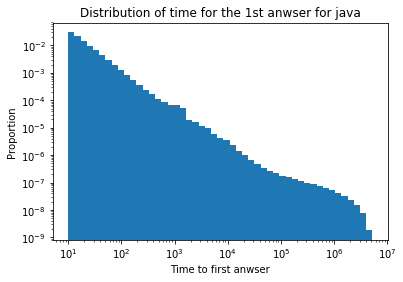

In [23]:
#HIstogram for Java
fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(pd_java_time.values, bins=np.logspace(1,np.log10(pd_java_time.values.max()), 50), density=True)
fig.canvas.draw()
plt.yscale('log')
plt.xscale('log')
# plt.xticks(rotation=30)
plt.xlabel('Time to first anwser')
plt.ylabel('Proportion')
plt.title('Distribution of time for the 1st anwser for java')
plt.show()

In [24]:
#We convert spark dataframe to pandas dataframe 
pd_python_time = python_df_response_time_per_question.select('Duration_minutes').toPandas()

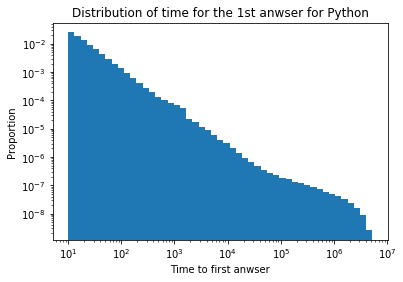

In [25]:
#HIstogram for Python
fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(pd_python_time.values, bins=np.logspace(1,np.log10(pd_python_time.values.max()), 50), density=True)
fig.canvas.draw()
plt.yscale('log')
plt.xscale('log')
# plt.xticks(rotation=30)
plt.xlabel('Time to first anwser')
plt.ylabel('Proportion')
plt.title('Distribution of time for the 1st anwser for Python')
plt.show()

These distribution are almost the same. They both follow a logarithmic distribution. For most of the questions on stackoverflow, the duration time for the first anwser is about 10min. 

We display all the statistical detail of the data set for Python (mean and std)


In [40]:
pd_python_time.Duration_minutes.mean()

132486.63222518357

In [41]:
pd_python_time.Duration_minutes.std()

519315.1998408248

We display all the statistical detail of the data set for Java (mean and std)


In [42]:
pd_java_time.Duration_minutes.mean()

117265.82542522086

In [43]:
pd_java_time.Duration_minutes.std()

476003.09542440664

In [44]:
#Median python
pd_python_time_sorted = pd_python_time.sort_values('Duration_minutes')
pd_python_time_sorted.quantile([0.25,0.5,0.75]) # show the quantile for python


,Duration_minutes
0.25,7.800000
0.50,24.116667
0.75,299.716667


In [45]:
#median java
pd_java_time_sorted = pd_java_time.sort_values('Duration_minutes')
pd_java_time_sorted.quantile([0.25,0.5,0.75])

,Duration_minutes
0.25,7.800000
0.50,24.116667
0.75,299.716667


The mean for both python and java is large, but the median is around 24 minutes. This is probably because some questions have there 1st awnsers,  10 years after the q 

# Question:
We believe that the response time is lower for questions related to Python (compare to Java). Contradict or confirm this assumption by estimating the proper statistic with bootstrapping. Visualize the 95% confidence intervals with box plots and describe your findings.

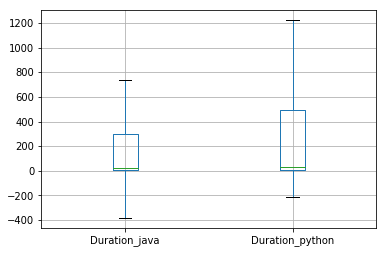

In [42]:
pd_python_time_sorted = pd_python_time.sort_values('Duration_minutes')
pd_python_time_sorted.quantile([0.25,0.5,0.75]) # show the quantile for python
pd_java_time_sorted = pd_java_time.sort_values('Duration_minutes')
pd_java_time_sorted.quantile([0.25,0.5,0.75])
time = pd.DataFrame()
time['Duration_java'] = pd_java_time_sorted['Duration_minutes']
time['Duration_python'] = pd_python_time_sorted['Duration_minutes']
boxplot = time.boxplot(column=['Duration_java','Duration_python'],showfliers=False)

# Answer:
Even if the mean and the median is almost the same for python and java, if we consider the quantiles for python and java, it seems that the duration time for the 1st anwser is less important in java topics than in python.

# Question:
Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.

In [ ]:
from pyspark.sql.functions import desc
posts_groupby_Tag = posts_final.groupby('Tags').count()
posts_5000_tags = posts_groupby_Tag.filter("`count` >= 5000").orderBy('count', ascending=False)
posts_5000_tags.head(20)


### Task E: What's up with PySpark?
The number of questions asked regarding a specific topic reflect the public’s interest on it. We are interested on the popularity of PySpark. Compute and plot the number of questions with the ```pyspark``` tag for 30-day time intervals. Do you notice any trend over time? Is there any correlation between time and number of questions?


In [44]:
#Getting pyspark questions
pyspark_questions = posts.filter(posts.Tags.contains('pyspark'))
print("Total number of pyspark questions: " + str(pyspark_questions.count()))

Total number of pyspark questions: 10484


In [45]:
pyspark_quest_date_parsed = pyspark_questions.withColumn('CreationDate', regexp_replace('CreationDate', ':', ''))

In [46]:
#Converting string to date thanks to the function declared in D.1 question
pyspark_quest_date_converted = pyspark_quest_date_parsed.withColumn('CreationDate', func(col('CreationDate')))
pyspark_quest_date_converted.printSchema()

root
 |-- CreationDate: timestamp (nullable = true)
 |-- Id: long (nullable = true)
 |-- ParentId: long (nullable = true)
 |-- PostTypeId: long (nullable = true)
 |-- Score: long (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ViewCount: long (nullable = true)



# Question:
Compute and plot the number of questions with the pyspark tag for 30-day time intervals

Do you notice any trend over time?

In [51]:
from pyspark.sql.functions import unix_timestamp, lit
from datetime import datetime, timedelta
import dateutil.relativedelta
#Getting date of 3 month ago because there is no data since this date
date = datetime.now() - dateutil.relativedelta.relativedelta(months=3)

cols = ['Period','Starting_Period_Date','Pyspark_Questions_Count']
lst = []
print("Number of pyspark questions for several 30-days intervals until 2014:")

#This loop is time consuming because we are fetching multiples intervals to get
for i in range(10):
    #calculating 30-days intervals every 7 months until 2014
    date = date - dateutil.relativedelta.relativedelta(months=4)
    date_30days_ago = date - dateutil.relativedelta.relativedelta(months=1)
    #Getting all questions between date and date_30days_ago
    pyspark_quest_perMonth = pyspark_quest_date_converted.filter(pyspark_quest_date_converted["CreationDate"] >= lit(date_30days_ago)) \
       .filter(pyspark_quest_date_converted["CreationDate"] <= lit(date))
    count = pyspark_quest_perMonth.count()
    #Adding date and pyspark question count to a list
    lst.append([str(date_30days_ago.month) + "/" +  str(date_30days_ago.year)[2:],date_30days_ago,count])
    print(date_30days_ago.strftime("%B") + " " +  str(date_30days_ago.year)+ ": " + str(count))
    date = date_30days_ago

#Adding list to a dataframe to calculate correlation
pyspark_question_count_per_month=pd.DataFrame(lst, columns=cols)

Number of pyspark questions for several 30-days intervals until 2014:
March 2018: 482
October 2017: 361
May 2017: 295
December 2016: 245
July 2016: 250
February 2016: 186
September 2015: 96
April 2015: 56
November 2014: 4
June 2014: 0


# Answer:
According to Wikipedia, Spark was created in 2014 (https://fr.wikipedia.org/wiki/Apache_Spark)
We can see, thanks to the cell's result above, that pyspark has been gaining reputation since 2014. 

# Question:
Is there any correlation between time and number of questions?

In [52]:
#Converting date to apply correlation
pyspark_question_count_per_month.Starting_Period_Date=pd.to_datetime(pyspark_question_count_per_month.Starting_Period_Date)
pyspark_question_count_per_month.Starting_Period_Date=pd.to_numeric(pyspark_question_count_per_month.Starting_Period_Date)
#Displaying correlation
print('Correlation between date and pyspark questions count: ' + 
      str(pyspark_question_count_per_month["Starting_Period_Date"].corr(pyspark_question_count_per_month["Pyspark_Questions_Count"])))

Correlation between date and pyspark questions count: 0.9824394493848322


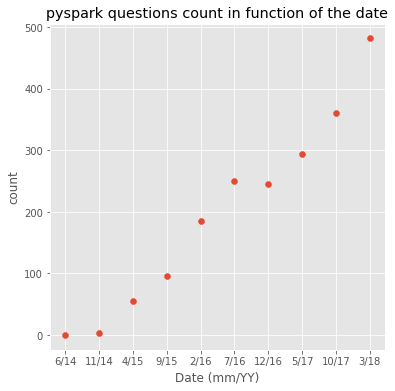

In [53]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#Displaying pyspark questions count in function of the date to see correlation
plt.figure(figsize=(6,6))
plt.scatter(pyspark_question_count_per_month["Period"], pyspark_question_count_per_month["Pyspark_Questions_Count"])

matplotlib.style.use('ggplot')
plt.title('pyspark questions count in function of the date')
plt.xlabel('Date (mm/YY)')
plt.ylabel('count')
plt.gca().invert_xaxis()
plt.show()

# Answer:
Thanks to the corr() function and the scatter plot, we can affirme that there is a strong correlation 
between the time and the number of question related to pyspark. It certainly comes from the fact that pyspark becomes more and more popular since its creation in 2014.